-----
-----
#**Codificación de variables categoricas**

---
---







##⚪ Codificaciones basadas en el target

---

1.	Target Encoding (Mean Encoding)
2.	Leave-One-Out Encoding (LOO):
3.	Weight of Evidence (WoE)


###**1.  Target Encoding (Mean Encoding)**
Si tu dataset es muy grande y con muchas categorías.

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 1.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

In [3]:
from category_encoders import TargetEncoder,LeaveOneOutEncoder,WOEEncoder

 Ejemplo con datos simulados

In [4]:
np.random.seed(42)

n = 100
df = pd.DataFrame({
    'canal': np.random.choice(['email', 'teléfono', 'visita'], size=n),
    'zona': np.random.choice(['norte', 'sur', 'este', 'oeste'], size=n),
    'producto': np.random.choice(['A', 'B', 'C',"D", "E", "F"], size=n),
    'genero': np.random.choice(['masculino', 'femenino'], size=n),
    'antiguedad_cliente': np.random.choice(['nuevo', 'medio', 'antiguo'], size=n),
    'compra': np.random.choice([0, 1], size=n, p=[0.6, 0.4])
})

print(df.head(10))

      canal   zona producto     genero antiguedad_cliente  compra
0    visita  oeste        D  masculino              nuevo       0
1     email  oeste        A   femenino              medio       0
2    visita  oeste        F  masculino              nuevo       0
3    visita   este        A   femenino              medio       1
4     email   este        A   femenino              nuevo       0
5     email   este        A   femenino              medio       0
6    visita  norte        C  masculino            antiguo       0
7  teléfono  oeste        F  masculino              nuevo       0
8    visita   este        A   femenino              nuevo       1
9    visita   este        D  masculino              nuevo       0


In [5]:
variables=df.select_dtypes(include="O").columns.tolist() #df.columns[:-1]
variables

['canal', 'zona', 'producto', 'genero', 'antiguedad_cliente']

####**🔹Implementación manual del TargetEncoder con pandas**

**Para una variable calculamos el target encoding**

In [6]:
targMean_canal=df.groupby(["producto"])["compra"].mean()
targMean_canal

,compra
producto,
A,0.423077
B,0.538462
C,0.421053
D,0.150000
E,0.571429
F,0.266667


In [7]:
df["producto"].map(targMean_canal)#.head()

,producto
0,0.150000
1,0.423077
2,0.266667
3,0.423077
4,0.423077
...,...
95,0.150000
96,0.538462
97,0.423077
98,0.150000


**calculamos el target enconding para todas las variables categoricas**

In [8]:
dic_targMean={i:df.groupby([i])["compra"].mean() for i in variables}
dic_targMean

{'canal': canal
 email       0.333333
 teléfono    0.361111
 visita      0.419355
 Name: compra, dtype: float64,
 'zona': zona
 este     0.411765
 norte    0.545455
 oeste    0.280000
 sur      0.210526
 Name: compra, dtype: float64,
 'producto': producto
 A    0.423077
 B    0.538462
 C    0.421053
 D    0.150000
 E    0.571429
 F    0.266667
 Name: compra, dtype: float64,
 'genero': genero
 femenino     0.400000
 masculino    0.333333
 Name: compra, dtype: float64,
 'antiguedad_cliente': antiguedad_cliente
 antiguo    0.300000
 medio      0.384615
 nuevo      0.419355
 Name: compra, dtype: float64}

In [9]:
dic_targMean["canal"]

,compra
canal,
email,0.333333
teléfono,0.361111
visita,0.419355


Realizamos la Transformacion

In [10]:
dftrans_tarmean=df[variables].apply(lambda x:x.map(dic_targMean[x.name]))#.rename(columns=lambda x:x+"_targetmean")
dftrans_tarmean.head()

,canal,zona,producto,genero,antiguedad_cliente
0,0.419355,0.280000,0.150000,0.333333,0.419355
1,0.333333,0.280000,0.423077,0.400000,0.384615
2,0.419355,0.280000,0.266667,0.333333,0.419355
3,0.419355,0.411765,0.423077,0.400000,0.384615
4,0.333333,0.411765,0.423077,0.400000,0.419355


####🔹Aplicación del TargetEncoder con la librería category_encoders.

In [11]:
pre_targMean=TargetEncoder(handle_missing= 'value', handle_unknown = 'value',smoothing=1,min_samples_leaf=1,)#smoothing=0,min_samples_leaf=10
dffit_targmean=pre_targMean.fit_transform(df[variables], df['compra'])
dffit_targmean.head()

,canal,zona,producto,genero,antiguedad_cliente
0,0.419355,0.280000,0.150000,0.333333,0.419355
1,0.333333,0.280000,0.423077,0.400000,0.384615
2,0.419355,0.280000,0.266667,0.333333,0.419355
3,0.419355,0.411765,0.423077,0.400000,0.384615
4,0.333333,0.411765,0.423077,0.400000,0.419355


**Tecnica del Suavizado** <br>
El TargetEncoder por defecto aplica un suavizado para que las categorías con pocas observaciones no tomen un promedio extremo.<br>
Con pocas obevaciones nos referimos (ej: 1, 2 o 5 registros), sus medias serán muy ruidosas → el modelo puede sobreajustarse.<br>
Si una categoría aparece 1 sola vez y justo esa fila tiene target = 1, la media será 1.0 → el modelo creerá que esa categoría “garantiza” un positivo.<br>
El suavizado corrige esto:  
- **Pocas muestras** → el valor se acerca a la media global (*prior*).  
- **Muchas muestras** → el valor se acerca a la media real de la categoría.

```
TargetEncoder() de category_encoders
```

$$
Enc(c) = (1 - \lambda_c)\cdot prior + \lambda_c \cdot mean(y_c)
$$

Donde:
- $prior$ = media global del target  
- $mean(y_c)$ = media del target en la categoría \(c\)  
- $(\lambda_c)$ = factor de suavizado (entre 0 y 1)  


---
donde λ se calcula con una función logística:

$$
 \lambda_c  = \frac{1}{1 + \exp\left(-\frac{n_c - \text{min_samples_leaf}}{\text{smoothing}}\right)}
$$

- \(n_c\) = número de observaciones en la categoría \(c\)  
- `min_samples_leaf` = mínimo de muestras para confiar en la categoría  
- `smoothing` = controla la “pendiente” del suavizado


In [12]:
precat_targMean=TargetEncoder(handle_missing= 'value', handle_unknown = 'value',)#smoothing=0,min_samples_leaf=10

In [13]:
dffit_targmean=precat_targMean.fit_transform(df[variables], df['compra'])
dffit_targmean.head()

,canal,zona,producto,genero,antiguedad_cliente
0,0.407029,0.313979,0.260000,0.336115,0.407029
1,0.341186,0.313979,0.404269,0.399121,0.382714
2,0.407029,0.313979,0.330987,0.336115,0.407029
3,0.407029,0.403503,0.404269,0.399121,0.382714
4,0.341186,0.403503,0.404269,0.399121,0.407029


###**2. Leave-One-Out Encoding (LOO)**
Parecido al Target Encoding, pero al calcular la media para cada fila excluye la propia fila


####**🔹Implementación manual del LOO con pandas.**

In [14]:
df_loo = pd.DataFrame({
    "producto": ["A", "A","A", "B", "B", "B", "C", "C", "C", "C"],
    "target":   [0, 1, 0,0, 0, 1, 0, 1, 1, 0]  # Binaria en este caso
})
print(df_loo)
# Calcular suma y conteo por categoría
sumas = df_loo.groupby("producto")["target"].transform("sum").rename("suma")
conteos = df_loo.groupby("producto")["target"].transform("count").rename("cont")
print(pd.concat([sumas,conteos - 1],axis=1))
#print((conteos - 1))
# Fórmula vectorizada de Leave-One-Out
df_loo["producto_LOO"] = (sumas - df_loo["target"]) / (conteos - 1)

print("\nDatos con Leave-One-Out Encoding:")
print(df_loo)


  producto  target
0        A       0
1        A       1
2        A       0
3        B       0
4        B       0
5        B       1
6        C       0
7        C       1
8        C       1
9        C       0
   suma  cont
0     1     2
1     1     2
2     1     2
3     1     2
4     1     2
5     1     2
6     2     3
7     2     3
8     2     3
9     2     3

Datos con Leave-One-Out Encoding:
  producto  target  producto_LOO
0        A       0      0.500000
1        A       1      0.000000
2        A       0      0.500000
3        B       0      0.500000
4        B       0      0.500000
5        B       1      0.000000
6        C       0      0.666667
7        C       1      0.333333
8        C       1      0.333333
9        C       0      0.666667


In [15]:
sumas_loo = df.groupby("producto")["compra"].transform("sum")
conteos_loo = df.groupby("producto")["compra"].transform("count")

# Fórmula vectorizada de Leave-One-Out
df["producto_LOO"] = (sumas_loo - df["compra"]) / (conteos_loo - 1)

print("\nDatos con Leave-One-Out Encoding:")
print(df[["producto","compra","producto_LOO"]])



Datos con Leave-One-Out Encoding:
   producto  compra  producto_LOO
0         D       0      0.157895
1         A       0      0.440000
2         F       0      0.285714
3         A       1      0.400000
4         A       0      0.440000
..      ...     ...           ...
95        D       0      0.157895
96        B       0      0.583333
97        A       0      0.440000
98        D       0      0.157895
99        D       0      0.157895

[100 rows x 3 columns]


#### 🔹Aplicación del LeaveOneOutEncoder con la librería category_encoders.

In [16]:
precat_loo=LeaveOneOutEncoder(handle_unknown="value",handle_missing="value",sigma=0.01,random_state=123)

In [17]:
dffit_loo=precat_loo.fit_transform(df[variables], df['compra'])
dffit_loo.head()

,canal,zona,producto,genero,antiguedad_cliente
0,0.428629,0.293539,0.159005,0.343517,0.439981
1,0.347178,0.285898,0.437368,0.404030,0.392645
2,0.434560,0.293744,0.292002,0.338662,0.431206
3,0.393975,0.404175,0.402753,0.391265,0.363598
4,0.341761,0.424138,0.439972,0.406821,0.433296


**Hiperparametros del metodo LOO**

$
\text{Valor codificado}_i \;=\; \frac{\sum_{j \in \text{misma categoría}} y_j \;-\; y_i}{n - 1} \;+\; \text{ruido}
$

El ruido ~ Normal(0, sigma).


###**3. Weight of Evidence (WoE)**
Transforma categorías en función de la razón de proporciones entre positivos y negativos.<BR>
Muy usado en modelos de riesgo de crédito y problemas de clasificación binaria



El WOE para un bin o categoría se define como:

$
WOE = \ln\left(\frac{\text{Proporción de Buenos}}{\text{Proporción de Malos}}\right)
$
ó
$
\ln(\text{%Buenos}) - \ln(\text{%Malos})
$

$
\text{Proporción de Buenos} = \frac{\text{Buenos en el bin}}{\text{Total de Buenos}}
$

$
\text{Proporción de Malos} = \frac{\text{Malos en el bin}}{\text{Total de Malos}}
$


| Bin de Edad     | Buenos | Malos | % Buenos | % Malos |   WOE   |
|-----------------|--------|-------|----------|---------|---------|
| 18–30 años      | 120    | 180   | 0.24     | 0.36    | -0.405  |
| 31–45 años      | 300    | 200   | 0.60     | 0.40    |  0.405  |
| 46–65 años      | 80     | 120   | 0.16     | 0.24    | -0.405  |
| **TOTAL**       | **500**|**500**| **1.00** | **1.00**|    —    |


---
* WOE positivo → más buenos
* WOE negativo → más malos


| WOE             | Interpretación                                 |
| --------------- | ---------------------------------------------- |
| **de 0 a ±0.1** | efecto muy débil                               |
| **±0.1 a ±0.3** | efecto moderado                                |
| **±0.3 a ±0.6** | efecto fuerte                                  |
| **> ±0.6**      | efecto muy fuerte (alto riesgo de overfitting) |


####**🔹Implementación manual del WOEEncoder con pandas.**

In [18]:
tabla_woe=pd.crosstab(df["producto"],df["compra"],normalize="columns",)
tabla_woe

compra,0,1
producto,,
A,0.238095,0.297297
B,0.095238,0.189189
C,0.174603,0.216216
D,0.269841,0.081081
E,0.047619,0.108108
F,0.174603,0.108108


In [19]:
(np.log(tabla_woe.iloc[0,1])-np.log(tabla_woe.iloc[0,0])).round(4)

np.float64(0.2221)

In [20]:
tabla_woe=tabla_woe.assign(woe=lambda x:np.log(x[1])-np.log(x[0]))
print(tabla_woe)
df["producto_woe"] = df["producto"].map(tabla_woe["woe"])
df["producto_woe"].head()

compra           0         1       woe
producto                              
A         0.238095  0.297297  0.222062
B         0.095238  0.189189  0.686367
C         0.174603  0.216216  0.213763
D         0.269841  0.081081 -1.202384
E         0.047619  0.108108  0.819899
F         0.174603  0.108108 -0.479384


,producto_woe
0,-1.202384
1,0.222062
2,-0.479384
3,0.222062
4,0.222062


####🔹Aplicación del WOEEncoder con la librería category_encoders.

In [21]:
precat_woe=WOEEncoder(handle_unknown="value" ,handle_missing="value",regularization=0,sigma=0,random_state=123)

In [22]:
dffit_woe=precat_woe.fit_transform(df[variables], df['compra'])
dffit_woe.head()

,canal,zona,producto,genero,antiguedad_cliente
0,0.206794,-0.412245,-1.202384,-0.160930,0.206794
1,-0.160930,-0.412245,0.222062,0.126752,0.062213
2,0.206794,-0.412245,-0.479384,-0.160930,0.206794
3,0.206794,0.175542,0.222062,0.126752,0.062213
4,-0.160930,0.175542,0.222062,0.126752,0.206794


**Hiperparámetros del metodo woe**  
El parámetro regularization en WOEEncoder añade pseudo-conteos a las frecuencias de cada categoría, lo que evita valores extremos o infinitos cuando hay pocos datos y hace más estable la codificación, mientras que sigma introduce un ruido gaussiano controlado sobre el WoE ya calculado para reducir el sobreajuste y lograr que la representación de las categorías sea más robusta y generalizable.

| Categoría | Buenos | Malos | % Buenos | % Malos | WOE | ¿Funciona? |
|-----------|--------|-------|----------|---------|-----|-------------|
| A         | 50     | 100   | 0.25     | 0.50    | -0.693 | ✅ válido |
| B         | 0      | 80    | 0.00     | 0.40    | -∞    | ❌ ERROR (cero buenos) |
| C         | 150    | 0     | 0.75     | 0.00    | +∞    | ❌ ERROR (cero malos) |
| **TOTAL** | 200    | 180   | 1.00     | 1.00    | —     | — |


**🔹 Regularización**

$
WOE_{reg}(c) \;=\; \ln \left(
\frac{\tfrac{N_c^{1} + \alpha}{N^{1} + 2\alpha}}
     {\tfrac{N_c^{0} + \alpha}{N^{0} + 2\alpha}}
\right)
$

- $N_c^{1}$: número de casos con target=1 en la categoría \(c\)  
- $N_c^{0}$: número de casos con target=0 en la categoría \(c\)  
- $N^{1}, N^{0}$: totales globales  
- $\alpha = \text{regularization}\$: pseudo-conteo añadido  

---

**🔹 Ruido gaussiano (sigma)**

$
WOE_{final}(c) \;=\; WOE_{reg}(c) \;+\; \epsilon
$

donde  

$
\epsilon \;\sim\; \mathcal{N}(0, \sigma^2)
$

- $\sigma = \text{sigma}$: desviación estándar del ruido  
- Si $\sigma = 0$ → no se añade ruido  
- Si $\sigma > 0$ → se añade ruido gaussiano para evitar overfitting  




```
WOEEncoder(handle_unknown="value" ,regularization=1,handle_missing="value",sigma=0.05)
```



## ⚪ Codificaciones basadas solo en la variable categórica

---
1.	One-Hot Encoding.
2.	Label Encoding.
3.  Ordinal Encoding


###**1. One-Hot Encoding (OHE)**
Transforma cada categoría en una columna binaria (0/1).

####🔹Implementación manual del OHE con pandas.

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

| producto | A | B | C |
| -------- | - | - | - |
| A        | 1 | 0 | 0 |
| A        | 1 | 0 | 0 |
| A        | 1 | 0 | 0 |
| B        | 0 | 1 | 0 |
| B        | 0 | 1 | 0 |
| B        | 0 | 1 | 0 |
| C        | 0 | 0 | 1 |
| C        | 0 | 0 | 1 |
| C        | 0 | 0 | 1 |
| C        | 0 | 0 | 1 |


In [24]:
df_ohe = pd.get_dummies(df, columns=variables, dtype=int)#drop_first=True
df_ohe.head()

,compra,producto_LOO,producto_woe,canal_email,canal_teléfono,canal_visita,zona_este,zona_norte,zona_oeste,zona_sur,...,producto_B,producto_C,producto_D,producto_E,producto_F,genero_femenino,genero_masculino,antiguedad_cliente_antiguo,antiguedad_cliente_medio,antiguedad_cliente_nuevo
0,0,0.157895,-1.202384,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1
1,0,0.440000,0.222062,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0.285714,-0.479384,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1
3,1,0.400000,0.222062,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0.440000,0.222062,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1


####🔹Aplicación del OneHotEncoder con la librería sklearn.preprocessing.

In [25]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [26]:
one_hot=OneHotEncoder(drop=None,handle_unknown='ignore', sparse_output=False,dtype=int)
ohe_array=one_hot.fit_transform(df[variables])
ohe_array
#sparse_output=False, devuelve un array denso
#drop="first" → elimina la primera categoría.
#handle_unknown="ignore": Ignora las categorías nuevas y pone un vector de ceros para esa fila
#ohe_array.toarray()

array([[0, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0]])

| producto | **OneHot: A** | **OneHot: B** | **OneHot: C** | → (*drop=None*) | **OHE B** | **OHE C** | → (*drop='first'*)     |
| -------- | ------------- | ------------- | ------------- | --------------- | --------- | --------- | ---------------------- |
| A        | 1             | 0             | 0             |                 | 0         | 0         | (categoría referencia) |
| A        | 1             | 0             | 0             |                 | 0         | 0         | (categoría referencia) |
| A        | 1             | 0             | 0             |                 | 0         | 0         | (categoría referencia) |
| B        | 0             | 1             | 0             |                 | 1         | 0         |                        |
| B        | 0             | 1             | 0             |                 | 1         | 0         |                        |
| B        | 0             | 1             | 0             |                 | 1         | 0         |                        |
| C        | 0             | 0             | 1             |                 | 0         | 1         |                        |
| C        | 0             | 0             | 1             |                 | 0         | 1         |                        |
| C        | 0             | 0             | 1             |                 | 0         | 1         |                        |
| C        | 0             | 0             | 1             |                 | 0         | 1         |                        |


In [27]:
df_ohe = pd.DataFrame(
    ohe_array,
    columns=one_hot.get_feature_names_out(variables),
    index=df.index  # mantener el mismo índice que df original
)
df_ohe.head()

,canal_email,canal_teléfono,canal_visita,zona_este,zona_norte,zona_oeste,zona_sur,producto_A,producto_B,producto_C,producto_D,producto_E,producto_F,genero_femenino,genero_masculino,antiguedad_cliente_antiguo,antiguedad_cliente_medio,antiguedad_cliente_nuevo
0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0
2,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1
3,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0
4,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1


In [28]:
df_ohe.shape

(100, 18)

Si la variable fuera binaria
```
he = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=int)
```


###**2. Label Enconding (LE)**
Asigna un número entero a cada categoría.



####🔹Implementación manual del LE con pandas.

factorize: asigna códigos numéricos en el orden en que aparecen las categorías en el dataset, no alfabéticamente.

In [ ]:
code, uniques = pd.factorize(df["producto"])
print(code)

print("Diccionario categorías:", dict(enumerate(uniques)))

[0 1 2 1 1 1 3 2 1 0 4 1 3 2 3 1 2 4 1 3 5 0 3 2 1 0 1 2 1 5 0 0 2 5 3 1 4
 1 1 3 1 5 5 0 2 4 1 1 3 2 5 4 0 5 2 0 3 3 1 2 4 0 5 2 2 3 1 1 0 3 2 4 3 0
 0 3 0 3 5 3 3 0 0 1 1 5 1 3 0 1 1 5 2 5 3 0 5 1 0 0]
Diccionario categorías: {0: 'D', 1: 'A', 2: 'F', 3: 'C', 4: 'E', 5: 'B'}


usando pd.Categorical: Puedes definir el orden de las categorías.

Puedes reutilizar el mismo mapeo en distintos datos (más estable que factorize).

In [ ]:
cat = pd.Categorical(df["producto"] )
print("Códigos entrenamiento:", cat.codes)
dict(enumerate(cat.categories))

Códigos entrenamiento: [3 0 5 0 0 0 2 5 0 3 4 0 2 5 2 0 5 4 0 2 1 3 2 5 0 3 0 5 0 1 3 3 5 1 2 0 4
 0 0 2 0 1 1 3 5 4 0 0 2 5 1 4 3 1 5 3 2 2 0 5 4 3 1 5 5 2 0 0 3 2 5 4 2 3
 3 2 3 2 1 2 2 3 3 0 0 1 0 2 3 0 0 1 5 1 2 3 1 0 3 3]


{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}

In [ ]:
df_categorical = df[variables].apply(lambda x: pd.Categorical(x).codes)
df_categorical.head()

,canal,zona,producto,genero,antiguedad_cliente
0,2,2,3,1,2
1,0,2,0,0,1
2,2,2,5,1,2
3,2,0,0,0,1
4,0,0,0,0,2


####🔹Aplicación del LabelEncoding con la librería sklearn.preprocessing.

LabelEncoder solo funciona columna por columna.<br>
Muy útil para targets categóricos.

In [ ]:
#LabelEncoder asigna números enteros en el orden en que aparecen las clases.

In [ ]:
le = LabelEncoder()
# Ajustar y transformar la columna
df["prod_labelE"] = le.fit_transform(df["producto"])
df[["producto", "prod_labelE"]].head()

,producto,prod_labelE
0,D,3
1,A,0
2,F,5
3,A,0
4,A,0


In [ ]:
le.inverse_transform(df["prod_labelE"])

array(['D', 'A', 'F', 'A', 'A', 'A', 'C', 'F', 'A', 'D', 'E', 'A', 'C',
       'F', 'C', 'A', 'F', 'E', 'A', 'C', 'B', 'D', 'C', 'F', 'A', 'D',
       'A', 'F', 'A', 'B', 'D', 'D', 'F', 'B', 'C', 'A', 'E', 'A', 'A',
       'C', 'A', 'B', 'B', 'D', 'F', 'E', 'A', 'A', 'C', 'F', 'B', 'E',
       'D', 'B', 'F', 'D', 'C', 'C', 'A', 'F', 'E', 'D', 'B', 'F', 'F',
       'C', 'A', 'A', 'D', 'C', 'F', 'E', 'C', 'D', 'D', 'C', 'D', 'C',
       'B', 'C', 'C', 'D', 'D', 'A', 'A', 'B', 'A', 'C', 'D', 'A', 'A',
       'B', 'F', 'B', 'C', 'D', 'B', 'A', 'D', 'D'], dtype=object)

In [ ]:
print("Clases:", le.classes_)

Clases: ['A' 'B' 'C' 'D' 'E' 'F']


Aplicación para todas las variables:

In [ ]:
label_fitfull=OrdinalEncoder()
col_nominal_label=label_fitfull.fit_transform(df[variables])

In [ ]:
df_label_nominal = pd.DataFrame(
    col_nominal_label,
    columns=variables,
    index=df.index  # mantener el mismo índice que df original
)
df_label_nominal.head()

,canal,zona,producto,genero,antiguedad_cliente
0,2.0,2.0,3.0,1.0,2.0
1,0.0,2.0,0.0,0.0,1.0
2,2.0,2.0,5.0,1.0,2.0
3,2.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,2.0


###**3. Ordinal Encoding**




####🔹Implementación manual del OE con pandas.

In [ ]:
df["antiguedad_cliente"].unique()

array(['nuevo', 'medio', 'antiguo'], dtype=object)

In [ ]:
# Definimos el orden manual
orden = {"nuevo": 0, "medio": 1, "antiguo": 2}

# Ordinal Encoding
df["antiguedad_cliente_cod"] = df["antiguedad_cliente"].map(orden)
df["antiguedad_cliente_cod"].head()

,antiguedad_cliente_cod
0,0
1,1
2,0
3,1
4,0


####🔹Aplicación del OrdinalEncoding con la librería sklearn.preprocessing.

In [29]:
orden = [
    ['nuevo', 'medio', 'antiguo'],  # orden para Educacion
   ['email', 'teléfono', 'visita']
]

In [30]:
encoder_ord = OrdinalEncoder(categories=orden)

ordinal_fit=encoder_ord.fit_transform(df[["antiguedad_cliente","canal"]])

In [31]:
df_label_ordinal = pd.DataFrame(
    ordinal_fit,
    columns=["antiguedad_cliente","canal"],
    index=df.index  # mantener el mismo índice que df original
)
df_label_ordinal.head()

,antiguedad_cliente,canal
0,0.0,2.0
1,1.0,0.0
2,0.0,2.0
3,1.0,2.0
4,0.0,0.0


-----
-----
#**Aplicación de Métodos de Codificación de Variables en Modelos de Machine Learning**

---
---

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score

 Los datos se relacionan con campañas de marketing directo (llamadas telefónicas) de una entidad bancaria.
 El objetivo de la clasificación es predecir si el cliente contratará un depósito a plazo fijo (variable y).

In [34]:
df_bank=pd.read_csv("bank-full.csv",sep=";")

In [41]:
print(df_bank.shape)
df_bank.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [42]:
var_cat=df_bank.select_dtypes(include="object").columns.tolist()
var_cat=list(set(var_cat)-set(["y","month"]))#+["campaign"]
print(len(var_cat))
var_cat

8


['job',
 'loan',
 'contact',
 'poutcome',
 'education',
 'default',
 'housing',
 'marital']

In [68]:
target=["y"]
df_bank[target].value_counts(normalize=True)

,proportion
y,
no,0.883015
yes,0.116985


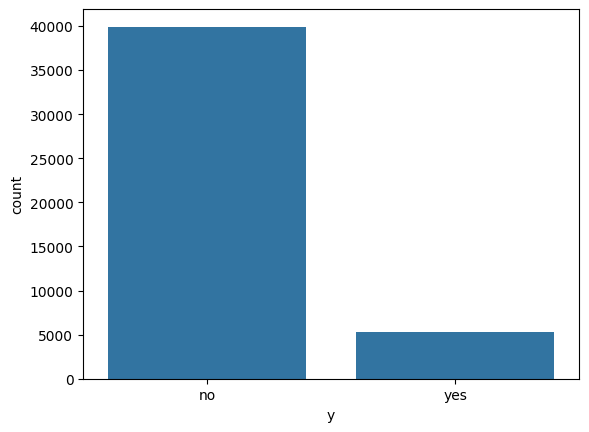

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=df_bank,x="y")
plt.show()

In [44]:
df_bank["marital"].value_counts()#marital job contact poutcome

,count
marital,
married,27214
single,12790
divorced,5207


In [45]:
df_bank["education"].value_counts()

,count
education,
secondary,23202
tertiary,13301
primary,6851
unknown,1857


In [46]:
df_bank["job"].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [47]:
df_bank["contact"].value_counts()

,count
contact,
cellular,29285
unknown,13020
telephone,2906


In [50]:
df_bank["poutcome"].value_counts()

,count
poutcome,
unknown,36959
failure,4901
other,1840
success,1511


In [51]:
df_bank["default"].unique(),df_bank["housing"].unique(),df_bank["loan"].unique(),df_bank["y"].unique()

(array(['no', 'yes'], dtype=object),
 array(['yes', 'no'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object))

In [53]:
orden=[
    ['tertiary', 'secondary', 'unknown', 'primary']#education
       ]

In [54]:
np.random.seed(12345)

In [55]:
x_train,x_test,y_train,y_test= train_test_split(df_bank[var_cat],df_bank['y'], test_size = 0.3, random_state = 2024,stratify=df_bank['y'])


### 🔹**Preprocesamiento y Modelo**

**Combinar metodos**

In [56]:
var_binarias=["default", "housing", "loan"]
var_oneh=["marital", "job", "contact", "poutcome"]
var_ordinal=["education"]

In [57]:
target_le=LabelEncoder()
y_train_le=target_le.fit_transform(y_train)
y_train_le
y_test_le=target_le.transform(y_test)
y_test_le

array([0, 0, 0, ..., 0, 0, 0])

In [69]:
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot_binary", OneHotEncoder(drop="if_binary",sparse_output=False),var_binarias),
        ("ordinal", OrdinalEncoder(categories=[["unknown","primary" ,'secondary','tertiary']]), var_ordinal ),
        ("onehot", OneHotEncoder(drop=None,handle_unknown='ignore', sparse_output=False,dtype=int),var_oneh ),
    ]
)

pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=2024,class_weight="balanced"))
])

pipeline_rf.fit(x_train, y_train_le)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot_binary',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['default', 'housing',
                                                   'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['unknown',
                                                                              'primary',
                                                                              'secondary',
                                                                              'tertiary']]),
                                                  ['education']),
                                                 ('onehot',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['marital', 'job', 'contact',
                                                   'poutcome'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=2024))])

In [ ]:
y_pred = pipeline_rf.predict(x_test)
y_pred_proba = pipeline_rf.predict_proba(x_test)[:, 1]


In [59]:
results=[]

In [60]:
results.append({
        "metodo": "combinado_basadocat",
      "Accuracy": accuracy_score(y_test_le, y_pred),
        "Precision": precision_score(y_test_le, y_pred),  #
        "Recall": recall_score(y_test_le, y_pred),
        "F1-score": f1_score(y_test_le, y_pred),
        "ROC AUC": roc_auc_score(y_test_le, y_pred_proba)
    })


In [61]:
results

[{'metodo': 'combinado_basadocat',
  'Accuracy': 0.7450604541433206,
  'Precision': 0.23670137911623979,
  'Recall': 0.5299306868304978,
  'F1-score': 0.3272373540856031,
  'ROC AUC': np.float64(0.6985221990541733)}]

In [62]:
metodos={
"target_encoder":
TargetEncoder(handle_missing= 'value', handle_unknown = 'value',smoothing=5,min_samples_leaf=5,),

"LOO":LeaveOneOutEncoder(handle_unknown="value" ,handle_missing="value",sigma=0.01),

"WOE":WOEEncoder(handle_unknown="value" ,regularization=5,handle_missing="value",sigma=0.01)}

#####################################################################################
for i,k in metodos.items():
    pipe = make_pipeline(k, RandomForestClassifier(random_state=1234,class_weight="balanced"))
    pipe.fit(x_train, y_train_le)
    y_pred = pipe.predict(x_test)
    y_pred_proba = pipe.predict_proba(x_test)[:, 1]

    results.append({
        "metodo": i,
      "Accuracy": accuracy_score(y_test_le, y_pred),
        "Precision": precision_score(y_test_le, y_pred),  #
        "Recall": recall_score(y_test_le, y_pred),
        "F1-score": f1_score(y_test_le, y_pred),
        "ROC AUC": roc_auc_score(y_test_le, y_pred_proba)
    })


### 🔹 Resultados

In [70]:
df_results = pd.DataFrame(results).sort_values(by="Recall", ascending=False)
df_results

,metodo,Accuracy,Precision,Recall,F1-score,ROC AUC
0,combinado_basadocat,0.745060,0.236701,0.529931,0.327237,0.698522
3,WOE,0.744249,0.234181,0.522369,0.323386,0.699642
1,target_encoder,0.744249,0.234031,0.521739,0.323122,0.699120
2,LOO,0.888307,0.562718,0.203529,0.298936,0.718240


In [ ]:
# ruta data :https://archive.ics.uci.edu/dataset/222/bank+marketing